# Beer Sales Prediction Analysis Notebook
## Data Loading & Basic Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

### Pandemic Data Analysis

/var/folders/p7/xyrxrkz530dgfqm2hw8gz6ph0000gn/T/ipykernel_28549/2952778760.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pandemic = pd.read_csv(
/var/folders/p7/xyrxrkz530dgfqm2hw8gz6ph0000gn/T/ipykernel_28549/2952778760.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pandemic = pd.read_csv(


,date,confirmed,deaths,recovered
count,92,92.000000,92.000000,92.000000
mean,2020-12-16 12:00:00,49702.250000,799.695652,39157.032609
min,2020-11-01 00:00:00,26732.000000,468.000000,24395.000000
25%,2020-11-23 18:00:00,31639.500000,512.250000,26799.250000
50%,2020-12-16 12:00:00,46984.000000,639.500000,33796.000000
75%,2021-01-08 06:00:00,68165.250000,1106.250000,49595.250000
max,2021-01-31 00:00:00,78508.000000,1425.000000,68309.000000
std,NaN,18197.406019,332.706739,14163.779800


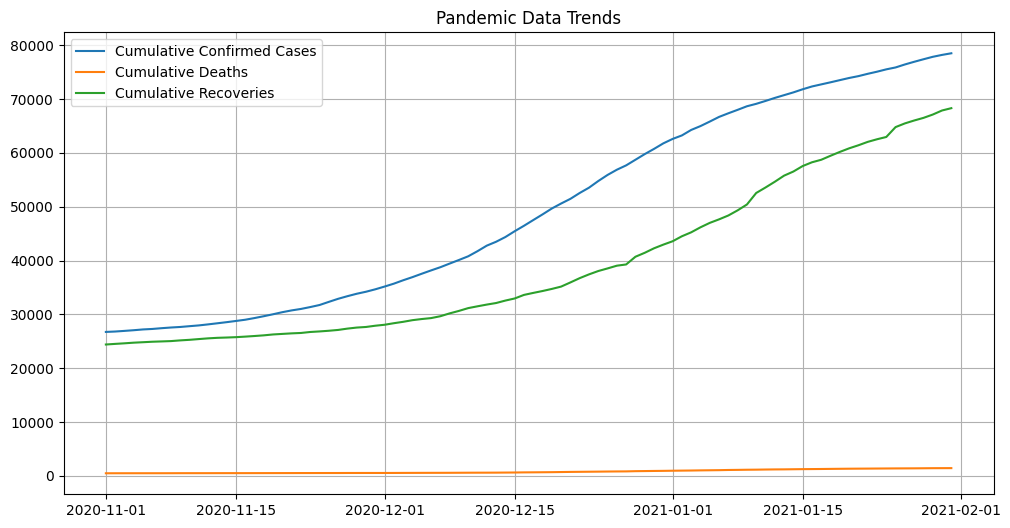

In [9]:
# Read data
pandemic = pd.read_csv(
    'raw_data/pandemic_data.csv',
    parse_dates=['date'],
    dayfirst=False,
    infer_datetime_format=True
)

# Statistics
display(pandemic.describe())

# Visualization
plt.figure(figsize=(12,6))
plt.plot(pandemic['date'], pandemic['confirmed'], label='Cumulative Confirmed Cases')
plt.plot(pandemic['date'], pandemic['deaths'], label='Cumulative Deaths')
plt.plot(pandemic['date'], pandemic['recovered'], label='Cumulative Recoveries')
plt.title('Pandemic Data Trends')
plt.legend()
plt.grid(True)
plt.show()

# Calculate daily new cases
pandemic['new_confirmed'] = pandemic['confirmed'].diff().fillna(0)
pandemic['active_cases'] = pandemic['confirmed'] - pandemic['deaths'] - pandemic['recovered']

### Sales Data Analysis

Sample dates in sales data:
0   2020-12-01
1   2020-12-02
2   2020-12-03
Name: date, dtype: datetime64[ns]

Actual Sales Statistics:


/var/folders/p7/xyrxrkz530dgfqm2hw8gz6ph0000gn/T/ipykernel_28549/2866856166.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  sales = pd.read_csv(
/var/folders/p7/xyrxrkz530dgfqm2hw8gz6ph0000gn/T/ipykernel_28549/2866856166.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales = pd.read_csv(


,actual
count,62.000000
mean,23.206218
std,16.523508
min,0.000000
25%,3.637190
50%,31.752088
75%,36.781922
max,47.255637



Forecast Statistics:


,forecast
count,121.000000
mean,26.916098
std,15.674976
min,0.004337
25%,7.645682
50%,32.818857
75%,38.388400
max,49.157352


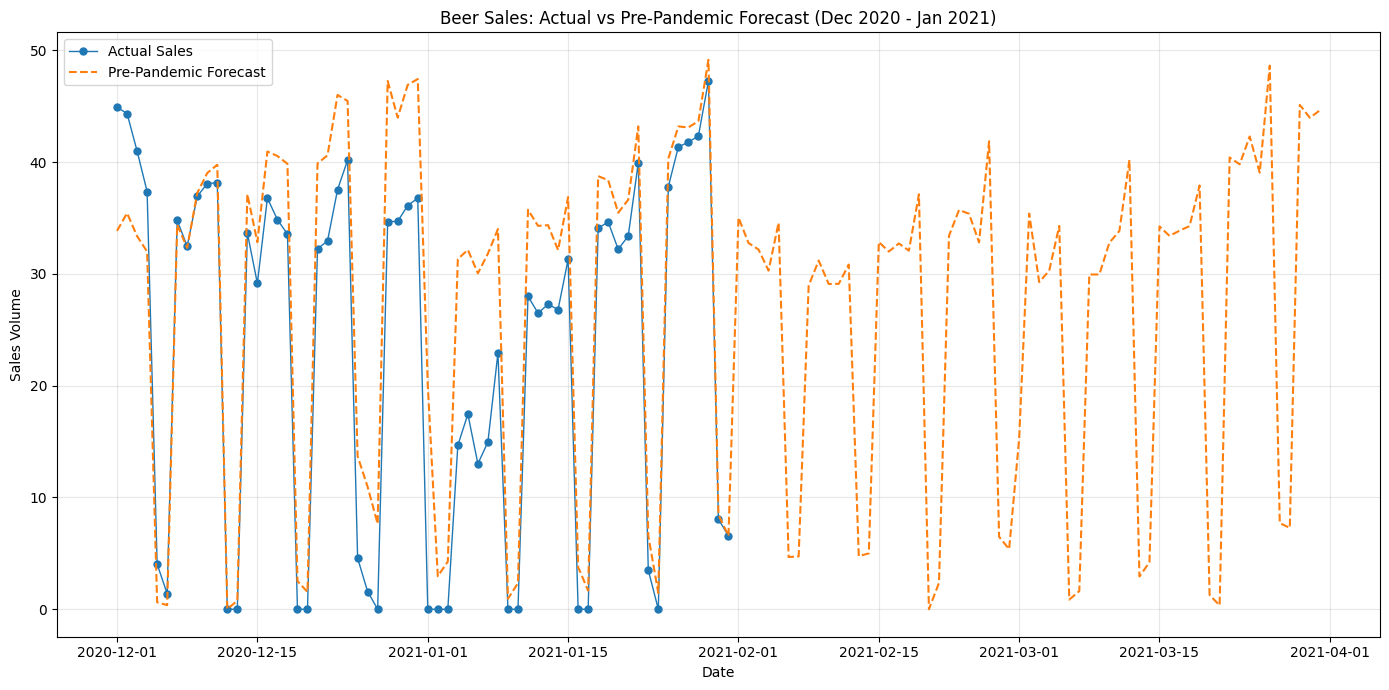

In [10]:
# Read data with correct date format
sales = pd.read_csv(
    'raw_data/sales&forecast_data.csv',
    parse_dates=['date'],
    dayfirst=False,  # MM/DD/YY format
    infer_datetime_format=True
)

# Verify date conversion
print("Sample dates in sales data:")
print(sales['date'].head(3))

# Split data into actual and forecast
actual_sales = sales[['date', 'real']].rename(columns={'real': 'actual'}).dropna()
forecast_sales = sales[['date', 'forecast']]

# Calculate statistics
print('\nActual Sales Statistics:')
display(actual_sales[['actual']].describe())
print('\nForecast Statistics:')
display(forecast_sales[['forecast']].describe())

# Visualization with improved formatting
plt.figure(figsize=(14, 7))
plt.plot(actual_sales['date'], actual_sales['actual'], 
         label='Actual Sales', marker='o', markersize=5, linewidth=1)
plt.plot(forecast_sales['date'], forecast_sales['forecast'], 
         label='Pre-Pandemic Forecast', linestyle='--', linewidth=1.5)
plt.title('Beer Sales: Actual vs Pre-Pandemic Forecast (Dec 2020 - Jan 2021)')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Data Integration Analysis

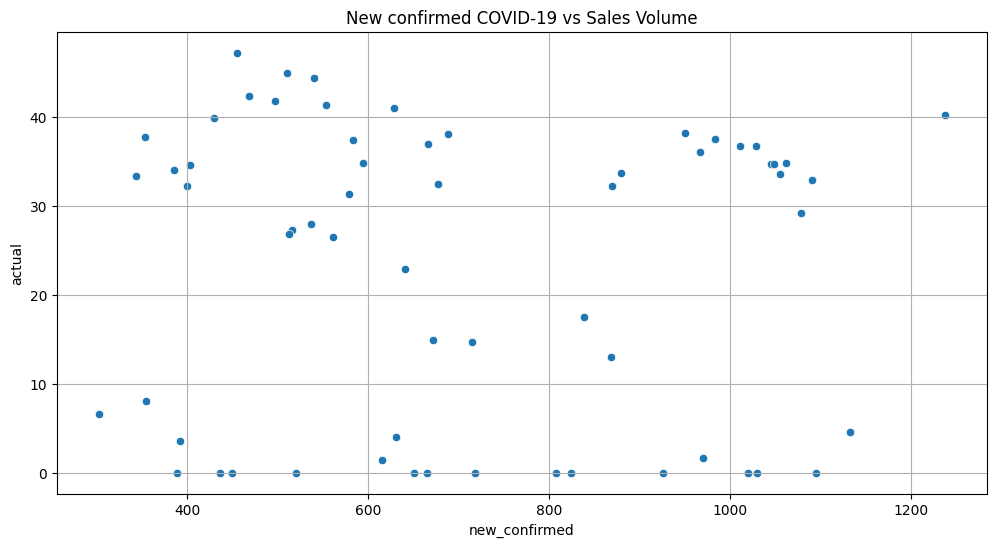

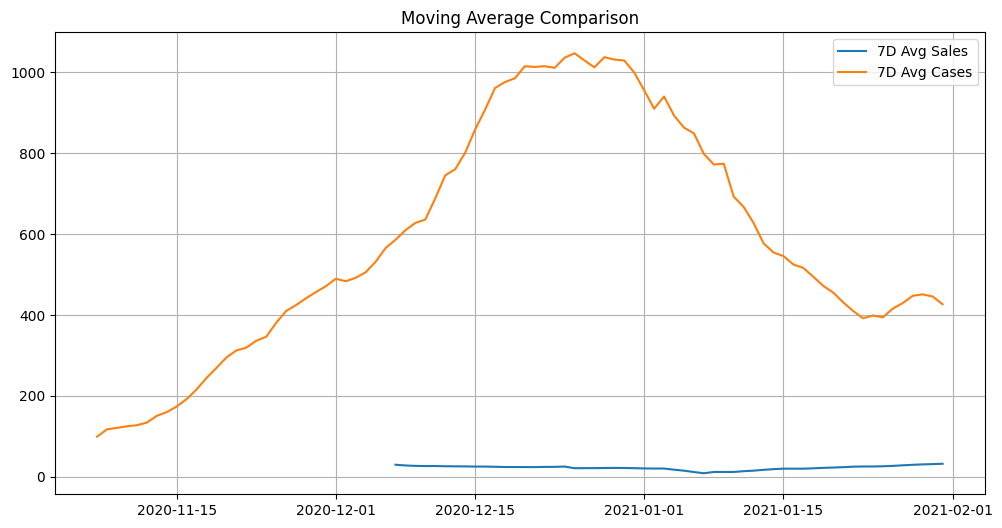

In [11]:
# Merge data
merged_df = pd.merge(pandemic, actual_sales, on='date', how='left')

# Correlation Analysis
plt.figure(figsize=(12,6))
sns.scatterplot(x='new_confirmed', y='actual', data=merged_df)
plt.title('New confirmed COVID-19 vs Sales Volume')
plt.grid(True)
plt.show()

# Moving Averages
merged_df['7day_avg_sales'] = merged_df['actual'].rolling(window=7).mean()
merged_df['7day_avg_cases'] = merged_df['new_confirmed'].rolling(window=7).mean()

plt.figure(figsize=(12,6))
plt.plot(merged_df['date'], merged_df['7day_avg_sales'], label='7D Avg Sales')
plt.plot(merged_df['date'], merged_df['7day_avg_cases'], label='7D Avg Cases')
plt.title('Moving Average Comparison')
plt.legend()
plt.grid(True)
plt.show()

### Lag correlation analysis

Lagged Correlation (new_confirmed vs actual):
new_confirmed_lag1   -0.225237
new_confirmed_lag2   -0.228675
new_confirmed_lag3   -0.252032
new_confirmed_lag4   -0.256566
new_confirmed_lag5   -0.152846
new_confirmed_lag6   -0.077225
new_confirmed_lag7   -0.197660
Name: actual, dtype: float64


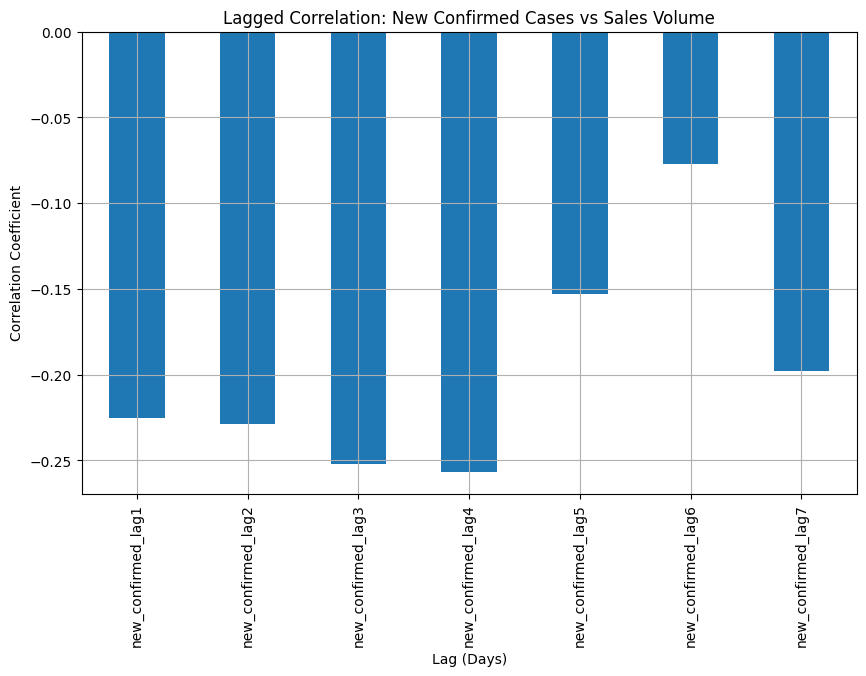

In [12]:
from pandas.plotting import lag_plot

# Create lagged features for new_confirmed
for lag in range(1, 8):  # Analyze lags from 1 to 7 days
    merged_df[f'new_confirmed_lag{lag}'] = merged_df['new_confirmed'].shift(lag)

# Correlation between lagged new_confirmed and actual sales
lagged_corr = merged_df.corr()['actual'][[f'new_confirmed_lag{lag}' for lag in range(1, 8)]]
print("Lagged Correlation (new_confirmed vs actual):")
print(lagged_corr)

# Plot the lagged correlation
plt.figure(figsize=(10, 6))
lagged_corr.plot(kind='bar')
plt.title('Lagged Correlation: New Confirmed Cases vs Sales Volume')
plt.xlabel('Lag (Days)')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()


### Sales Trends by Day of the Week

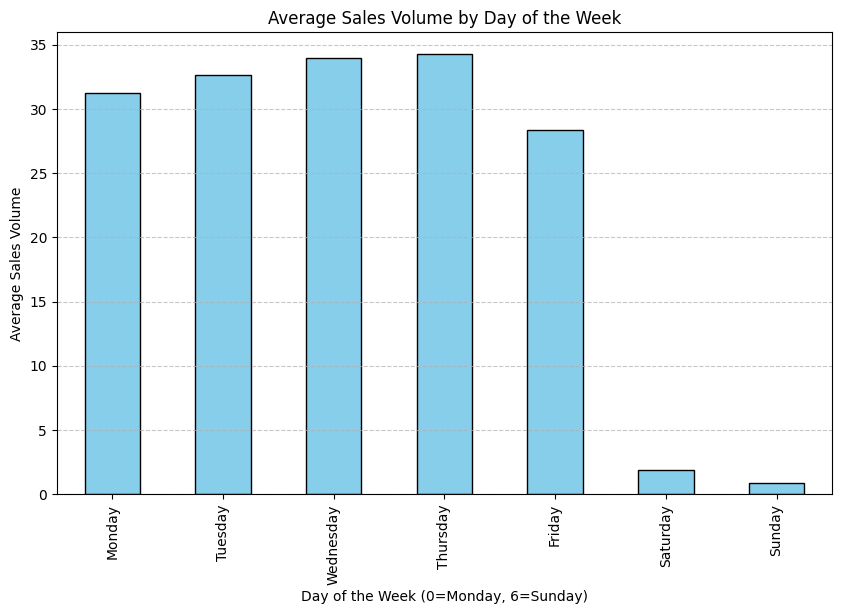

In [13]:
# Add day of the week as a feature
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek  # Monday=0, Sunday=6

# Calculate average sales by day of the week
avg_sales_by_day = merged_df.groupby('day_of_week')['actual'].mean()

# Plot average sales by day of the week
plt.figure(figsize=(10, 6))
avg_sales_by_day.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Sales Volume by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Sales Volume')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Forecast error

Correlation between forecast error and new confirmed cases: 0.32


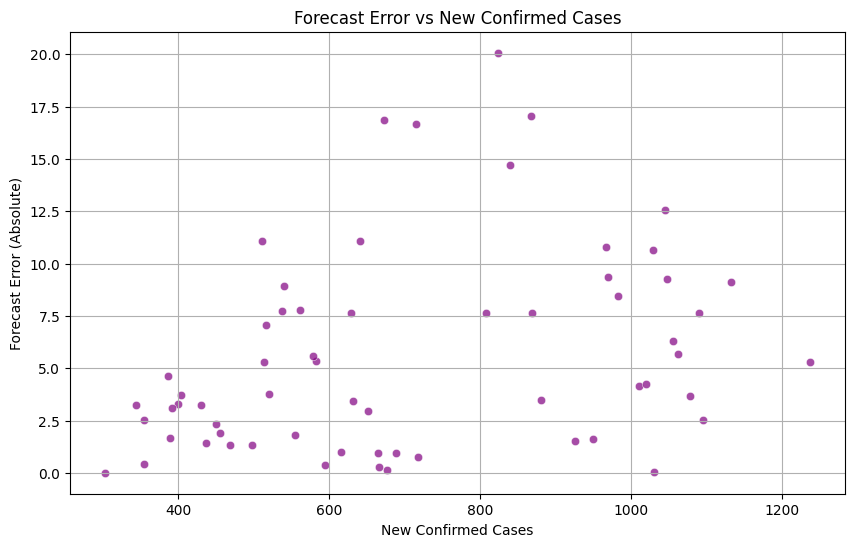

In [15]:
# Merge pandemic data with actual sales and forecast sales
merged_df = pd.merge(pandemic, actual_sales, on='date', how='left')
merged_df = pd.merge(merged_df, forecast_sales, on='date', how='left')

# Calculate forecast error (absolute difference between actual and forecast)
merged_df['forecast_error'] = abs(merged_df['actual'] - merged_df['forecast'])

# Correlation between forecast error and new confirmed cases
forecast_error_corr = merged_df[['forecast_error', 'new_confirmed']].corr().iloc[0, 1]
print(f"Correlation between forecast error and new confirmed cases: {forecast_error_corr:.2f}")

# Scatter plot of forecast error vs new confirmed cases
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='new_confirmed', y='forecast_error', color='purple', alpha=0.7)
plt.title('Forecast Error vs New Confirmed Cases')
plt.xlabel('New Confirmed Cases')
plt.ylabel('Forecast Error (Absolute)')
plt.grid(True)
plt.show()
